# Install and Configure Requirements

**Install Packages**

In [2]:
!pip install -q efficientnet keras-tuner kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.2 MB/s eta 0:00:00


**Import Libraries**

In [3]:
import os
import random
import itertools
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.applications import Xception, InceptionV3, EfficientNetB0, ResNet50, MobileNet
import efficientnet.tfkeras as efn
from keras import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import keras_tuner as kt
from sklearn.model_selection import KFold
import tensorflow as tf
import datetime
import pandas as pd
from pathlib import Path
import shutil
import logging
import json

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

**checking for gpu and adding growth**

In [ ]:
# Check if TensorFlow can detect the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# List the GPU devices that TensorFlow detected
print("GPU Devices: ", tf.config.list_physical_devices('GPU'))


Num GPUs Available:  0
GPU Devices:  []


In [ ]:
# Set GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

**Mount the Google Drive**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Configure Kaggle API Key and Download Dataset**

In [ ]:
# Set Kaggle Config Directory
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas"

In [ ]:
# Change Directory
%cd /content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/Dataset

/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/Dataset


In [ ]:
# Download dataset from kaggle
!kaggle datasets download samuelcortinhas/muffin-vs-chihuahua-image-classification

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification
License(s): CC0-1.0
 98% 466M/474M [00:06<00:00, 99.4MB/s]
100% 474M/474M [00:06<00:00, 77.3MB/s]


In [ ]:
# unzip
!unzip -q /content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/Dataset/muffin-vs-chihuahua-image-classification.zip

In [ ]:
# Remove
!rm /content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/Dataset/muffin-vs-chihuahua-image-classification.zip

# Loading and Visualizing the Data

**Set Train and Test Path**

In [6]:
train_path = "/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/Dataset/train"
test_path = "/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/Dataset/test"

**Function to Visualize the Data**

In [ ]:
def display_images(folder_path):
    num_images = 10
    classes = os.listdir(folder_path)
    image_paths_list = [glob.glob(f"{os.path.join(folder_path, class_name)}/*.jpg") for class_name in classes]
    all_image_paths = list(itertools.chain.from_iterable(image_paths_list))
    selected_images = random.sample(all_image_paths, num_images)
    fig, axes = plt.subplots(2, 5, figsize=(20, 7))


    for i, img_path in enumerate(selected_images):
        img = Image.open(img_path)
        ax = axes[i // 5, i % 5]
        ax.imshow(img)
        ax.set_title(os.path.basename(os.path.dirname(img_path)))
        ax.axis('off')

    plt.tight_layout()
    plt.show()


**Display Train Dataset**

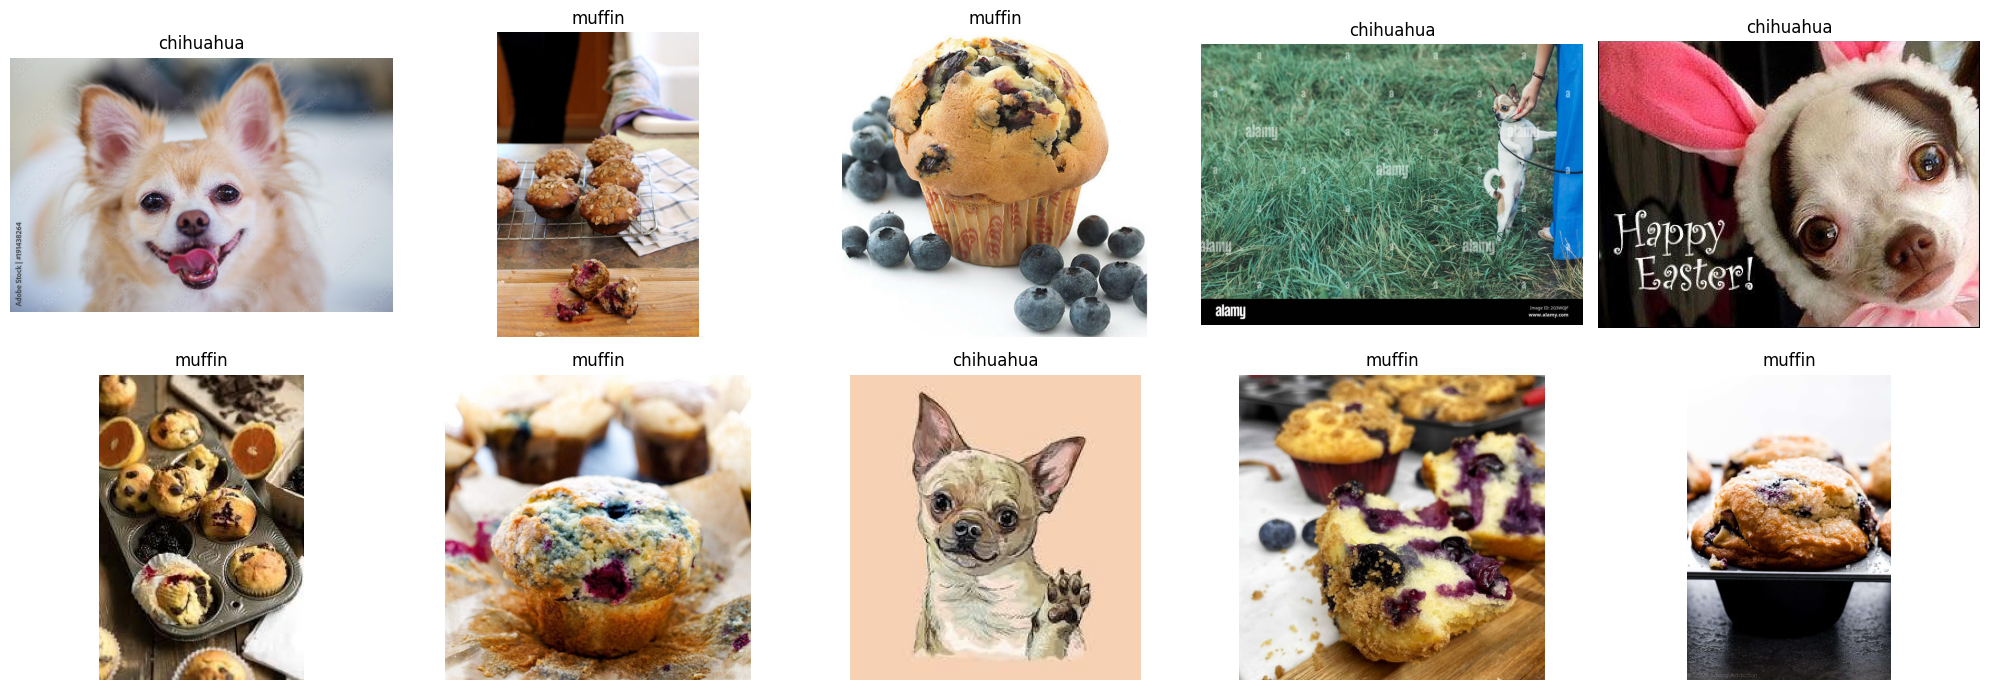

In [ ]:
display_images(train_path)

**Display Test Dataset**

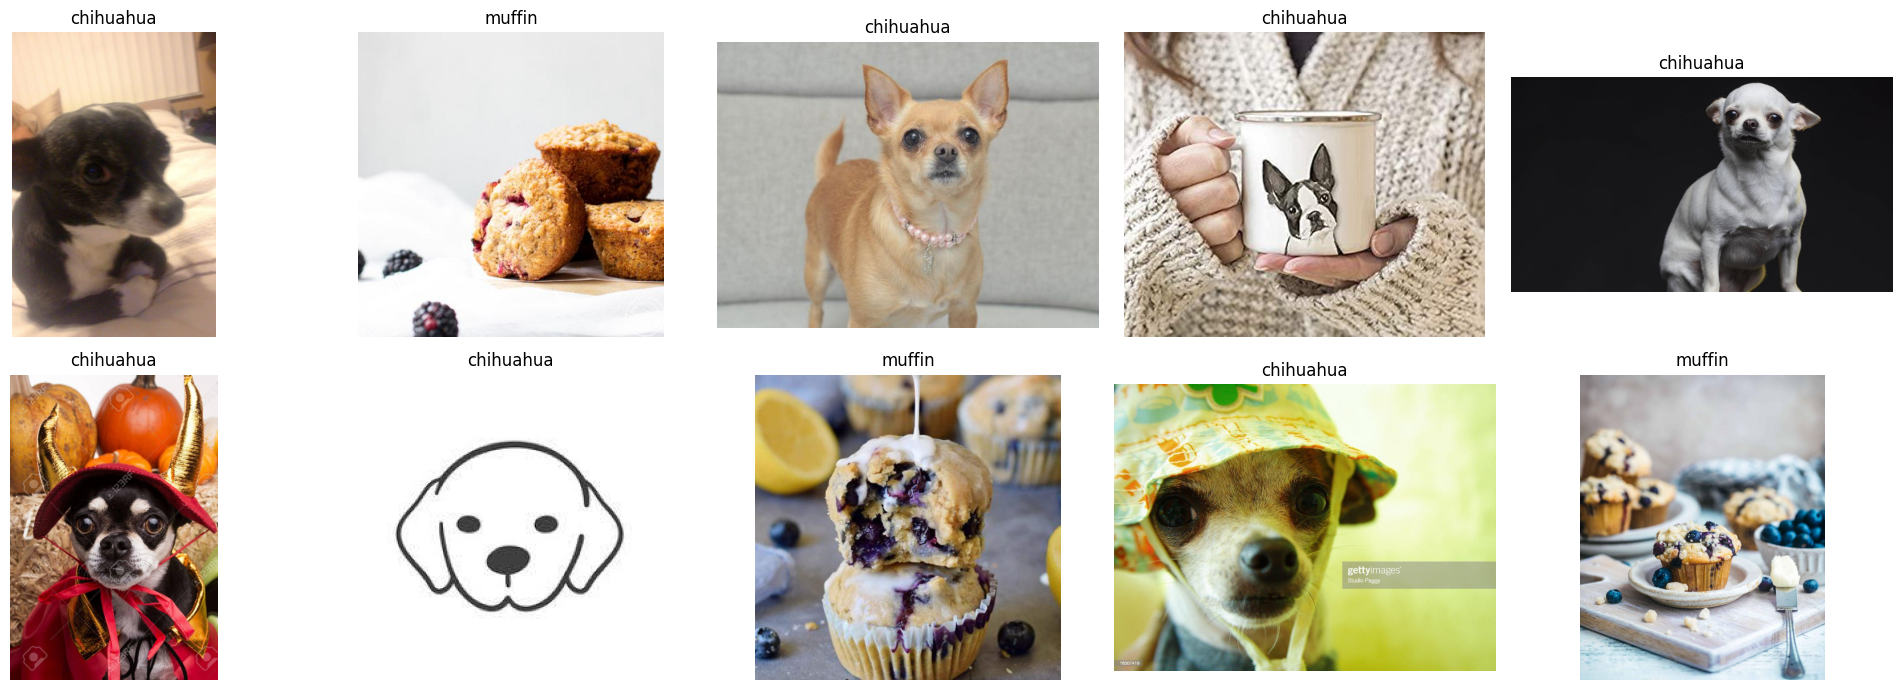

In [ ]:
display_images(test_path)

# PreProcessing

In [7]:
input_shape = (224, 224, 3)
weights = 'imagenet'
batch_size = 256
img_size = 224
num_classes = 2
num_folds = 5
max_trials = 20
num_epochs = 10

# Set up image data generator with rescaling and data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)

# Only rescale validation data
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up the test generator
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_size, img_size),
    batch_size= batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)


Found 1184 images belonging to 2 classes.


In [ ]:
def check_data_balance(generator):
    labels = generator.classes
    class_counts = np.bincount(labels)
    class_labels = list(generator.class_indices.keys())
    print(f"Class Distribution: {dict(zip(class_labels, class_counts))}")

print("\nTest")
check_data_balance(test_generator)


Test
Class Distribution: {'chihuahua': 640, 'muffin': 544}


In [ ]:
tuner_directory = '/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/dir'

In [ ]:
# Clear previous tuner directory
if os.path.exists(tuner_directory):
    shutil.rmtree(tuner_directory)

In [ ]:
# Create a DataFrame from the directory structure
def create_dataframe_from_directory(directory):
    classes = sorted(os.listdir(directory))
    data = []

    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            filenames = os.listdir(class_path)
            for filename in filenames:
                data.append([os.path.join(class_name, filename), class_name])

    return pd.DataFrame(data, columns=['filename', 'class'])

# Load the data as a DataFrame
train_df = create_dataframe_from_directory(train_path)
class_indices = {name: index for index, name in enumerate(sorted(train_df['class'].unique()))}
train_df['class'] = train_df['class'].astype(str)


In [ ]:
train_df.head()

filename      class
0  chihuahua/img_3_184.jpg  chihuahua
1  chihuahua/img_3_378.jpg  chihuahua
2  chihuahua/img_3_117.jpg  chihuahua
3   chihuahua/img_3_15.jpg  chihuahua
4  chihuahua/img_2_574.jpg  chihuahua

# HyperParameter Tuning

In [ ]:
tuner_directory

# Setup logging
logging.basicConfig(level=logging.INFO, filename='training_log.log', filemode='w',
                    format='%(asctime)s - %(levelname)s - %(message)s') # Sets up Python’s built-in logging module to record information about the program execution, errors, and informational messages.

# Custom metric for Zero-One Loss
def zero_one_loss(y_true, y_pred):
    return 1 - tf.keras.metrics.binary_accuracy(y_true, y_pred)

# Define the model-building function for Keras Tuner
def build_model(hp):
    architecture = hp.Choice('architecture', ['Xception', 'InceptionV3', 'EfficientNetB0'])
    units = hp.Int('units', min_value=32, max_value=128, step=32)
    activation = hp.Choice('activation', ['relu', 'tanh'])
    dropout = hp.Boolean('dropout')
    lr = hp.Float('learning_rate', min_value=1e-6, max_value=1e-1, sampling='LOG')

    if architecture == 'Xception':
        base_model = tf.keras.applications.Xception(include_top=False, input_shape=input_shape, weights='imagenet')
    elif architecture == 'InceptionV3':
        base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=input_shape, weights='imagenet')
    elif architecture == 'EfficientNetB0':
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')

    base_model.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(units, activation=activation)
    ])

    if dropout:
        model.add(Dropout(0.25))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy', zero_one_loss])

    return model

# Custom tuner
class CVTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        best_loss = float('inf')
        best_model = None
        best_model_path = ""

        kf = KFold(n_splits=num_folds, shuffle=True, random_state=50)
        fold_scores = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
            print(f'Fold {fold + 1}')
            logging.info(f'Starting Fold {fold + 1}')

            train_fold_df = train_df.iloc[train_idx]
            val_fold_df = train_df.iloc[val_idx]

            train_generator_fold = train_datagen.flow_from_dataframe(
                train_fold_df,
                directory=train_path,
                x_col='filename',
                y_col='class',
                target_size=(img_size, img_size),
                batch_size=batch_size,
                class_mode='binary',
                color_mode='rgb',
                shuffle=True
            )

            val_generator_fold = train_datagen.flow_from_dataframe(
                val_fold_df,
                directory=train_path,
                x_col='filename',
                y_col='class',
                target_size=(img_size, img_size),
                batch_size=batch_size,
                class_mode='binary',
                color_mode='rgb',
                shuffle=False
            )

            model = self.hypermodel.build(trial.hyperparameters)

            history = model.fit(
                train_generator_fold,
                validation_data=val_generator_fold,
                epochs=num_epochs,
                verbose=1
            )

            val_loss = model.evaluate(val_generator_fold, verbose=0)[0]
            fold_scores.append(val_loss)
            logging.info(f'Fold {fold + 1}: Validation Loss = {val_loss}')

            # Update best model if current fold's model is better
            if val_loss < best_loss:
                best_loss = val_loss
                if best_model_path:
                    os.remove(best_model_path)
                best_model = model
                best_model_path = os.path.join('/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/checkpoints', f'best_model_trial_{trial.trial_id}_val_loss_{best_loss:.4f}.keras')
                best_model.save(best_model_path)

        # Update trial with the best validation loss found among all folds
        self.oracle.update_trial(trial.trial_id, {'val_loss': best_loss})
        logging.info(f'Best model for trial {trial.trial_id} saved at {best_model_path} with loss {best_loss:.4f}')

# Instantiate the tuner
tuner = CVTuner(
    build_model,
    objective='val_loss',
    max_trials=max_trials,
    directory=tuner_directory,
    project_name='muffin_chihuahua_classification'
)

# Perform the search
tuner.search()
tuner.results_summary()

Trial 20 Complete [00h 59m 13s]
val_loss: 0.8028231859207153

Best val_loss So Far: 0.02650430239737034
Total elapsed time: 19h 48m 41s
Results summary
Results in /content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/dir/muffin_chihuahua_classification
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 16 summary
Hyperparameters:
architecture: Xception
units: 32
activation: relu
dropout: False
learning_rate: 0.00039898749499904464
Score: 0.02650430239737034

Trial 14 summary
Hyperparameters:
architecture: InceptionV3
units: 64
activation: tanh
dropout: True
learning_rate: 0.00010290426811853588
Score: 0.047022003680467606

Trial 09 summary
Hyperparameters:
architecture: InceptionV3
units: 32
activation: tanh
dropout: False
learning_rate: 9.009952912480081e-05
Score: 0.05450594425201416

Trial 15 summary
Hyperparameters:
architecture: InceptionV3
units: 64
activation: relu
dropout: False
learning_rate: 9.60930680993243e-06
Score: 0.09172321110963821

Trial 13 summa

# Train single model with Best Hyperparameter Found

Found 3786 validated image filenames belonging to 2 classes.
Found 947 validated image filenames belonging to 2 classes.
83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/10
15/15 [==============================] - 966s 61s/step - loss: 0.1955 - accuracy: 0.9295 - val_loss: 0.1789 - val_accuracy: 0.9789
Epoch 2/10
15/15 [==============================] - 39s 3s/step - loss: 0.0280 - accuracy: 0.9900 - val_loss: 0.2522 - val_accuracy: 0.9778
Epoch 3/10
15/15 [==============================] - 43s 3s/step - loss: 0.0068 - accuracy: 0.9982 - val_loss: 0.1621 - val_accuracy: 0.9863
Epoch 4/10
15/15 [==============================] - 44s 3s/step - loss: 0.0015 - accuracy: 0.9989 - val_loss: 0.1474 - val_accuracy: 0.9863
Epoch 5/10
15/15 [==============================] - 43s 3s/step - loss: 9.8817e-04 - accuracy: 0.9992 - val_loss: 0.1285 - val_accuracy: 0.9863
Epoch 6/10
15/15 [==============================] - 41s 3s/step - loss: 8.2790e-04 - accuracy: 0.9992 - val_

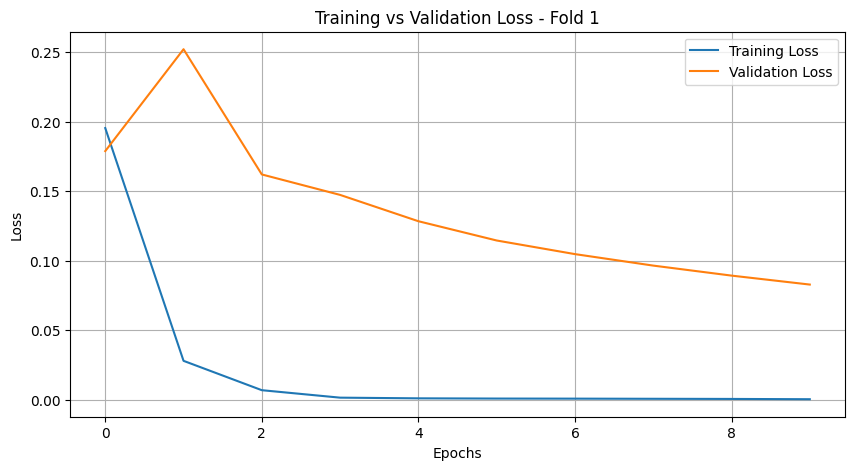

Found 3786 validated image filenames belonging to 2 classes.
Found 947 validated image filenames belonging to 2 classes.
Epoch 1/10
15/15 [==============================] - 67s 3s/step - loss: 0.2031 - accuracy: 0.9253 - val_loss: 0.1140 - val_accuracy: 0.9863
Epoch 2/10
15/15 [==============================] - 39s 3s/step - loss: 0.0235 - accuracy: 0.9931 - val_loss: 0.1804 - val_accuracy: 0.9863
Epoch 3/10
15/15 [==============================] - 40s 3s/step - loss: 0.0062 - accuracy: 0.9976 - val_loss: 0.1190 - val_accuracy: 0.9884
Epoch 4/10
15/15 [==============================] - 42s 3s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0702 - val_accuracy: 0.9905
Epoch 5/10
15/15 [==============================] - 40s 3s/step - loss: 3.9809e-04 - accuracy: 1.0000 - val_loss: 0.0621 - val_accuracy: 0.9884
Epoch 6/10
15/15 [==============================] - 38s 3s/step - loss: 1.4956e-04 - accuracy: 1.0000 - val_loss: 0.0551 - val_accuracy: 0.9894
Epoch 7/10
15/15 [=============

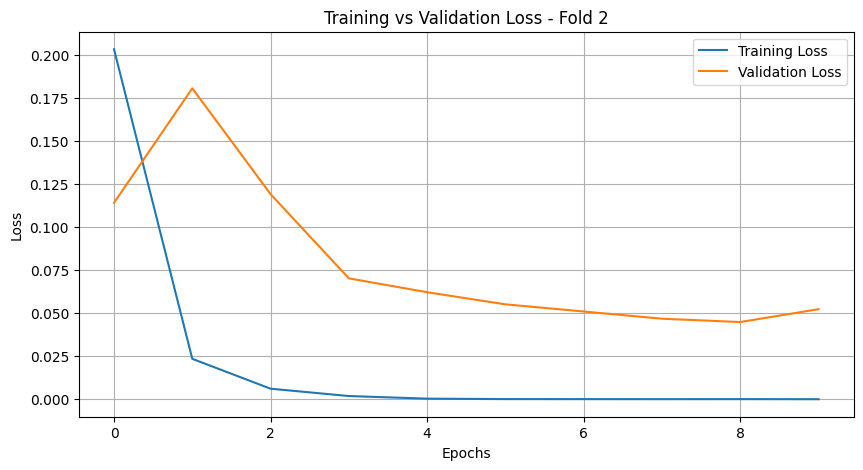

Found 3786 validated image filenames belonging to 2 classes.
Found 947 validated image filenames belonging to 2 classes.
Epoch 1/10
15/15 [==============================] - 64s 3s/step - loss: 0.2160 - accuracy: 0.9292 - val_loss: 0.2343 - val_accuracy: 0.9810
Epoch 2/10
15/15 [==============================] - 38s 3s/step - loss: 0.0182 - accuracy: 0.9945 - val_loss: 0.3104 - val_accuracy: 0.9799
Epoch 3/10
15/15 [==============================] - 39s 3s/step - loss: 0.0071 - accuracy: 0.9974 - val_loss: 0.2744 - val_accuracy: 0.9799
Epoch 4/10
15/15 [==============================] - 38s 3s/step - loss: 0.0023 - accuracy: 0.9989 - val_loss: 0.2104 - val_accuracy: 0.9842
Epoch 5/10
15/15 [==============================] - 38s 3s/step - loss: 0.0013 - accuracy: 0.9992 - val_loss: 0.1712 - val_accuracy: 0.9842
Epoch 6/10
15/15 [==============================] - 38s 2s/step - loss: 9.8462e-04 - accuracy: 1.0000 - val_loss: 0.1353 - val_accuracy: 0.9873
Epoch 7/10
15/15 [=================

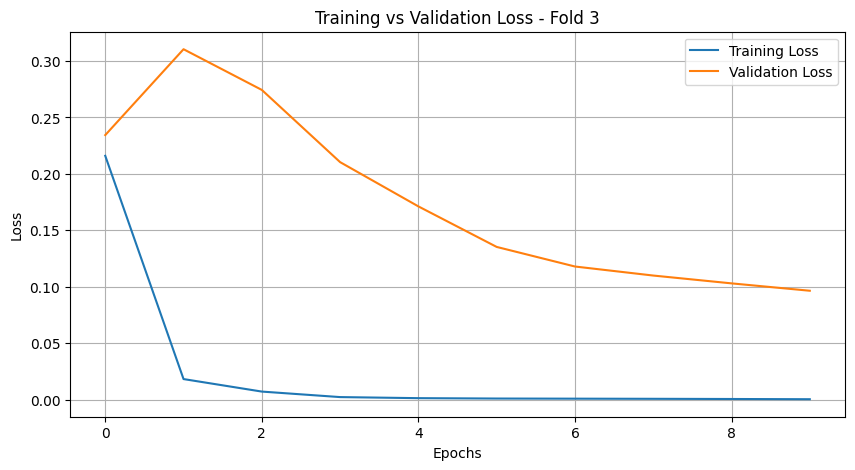

Found 3787 validated image filenames belonging to 2 classes.
Found 946 validated image filenames belonging to 2 classes.
Epoch 1/10
15/15 [==============================] - 84s 4s/step - loss: 0.2124 - accuracy: 0.9203 - val_loss: 0.1918 - val_accuracy: 0.9810
Epoch 2/10
15/15 [==============================] - 38s 2s/step - loss: 0.0179 - accuracy: 0.9937 - val_loss: 0.2301 - val_accuracy: 0.9799
Epoch 3/10
15/15 [==============================] - 39s 3s/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.0807 - val_accuracy: 0.9894
Epoch 4/10
15/15 [==============================] - 40s 3s/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0720 - val_accuracy: 0.9873
Epoch 5/10
15/15 [==============================] - 38s 3s/step - loss: 0.0061 - accuracy: 0.9989 - val_loss: 0.0845 - val_accuracy: 0.9863
Epoch 6/10
15/15 [==============================] - 38s 3s/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0792 - val_accuracy: 0.9852
Epoch 7/10
15/15 [=====================

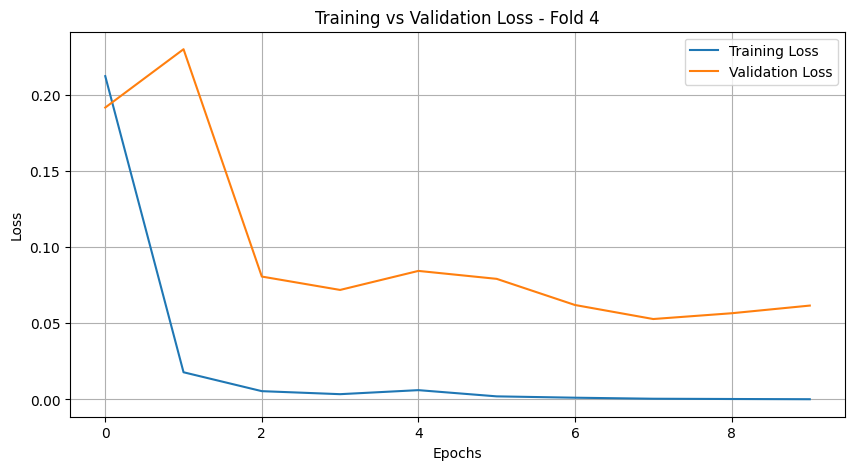

Found 3787 validated image filenames belonging to 2 classes.
Found 946 validated image filenames belonging to 2 classes.
Epoch 1/10
15/15 [==============================] - 66s 3s/step - loss: 0.1934 - accuracy: 0.9250 - val_loss: 0.1647 - val_accuracy: 0.9820
Epoch 2/10
15/15 [==============================] - 39s 3s/step - loss: 0.0225 - accuracy: 0.9918 - val_loss: 0.1406 - val_accuracy: 0.9863
Epoch 3/10
15/15 [==============================] - 39s 3s/step - loss: 0.0115 - accuracy: 0.9971 - val_loss: 0.1394 - val_accuracy: 0.9841
Epoch 4/10
15/15 [==============================] - 38s 3s/step - loss: 0.0036 - accuracy: 0.9989 - val_loss: 0.1336 - val_accuracy: 0.9799
Epoch 5/10
15/15 [==============================] - 40s 3s/step - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0969 - val_accuracy: 0.9841
Epoch 6/10
15/15 [==============================] - 39s 3s/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0471 - val_accuracy: 0.9894
Epoch 7/10
15/15 [=====================

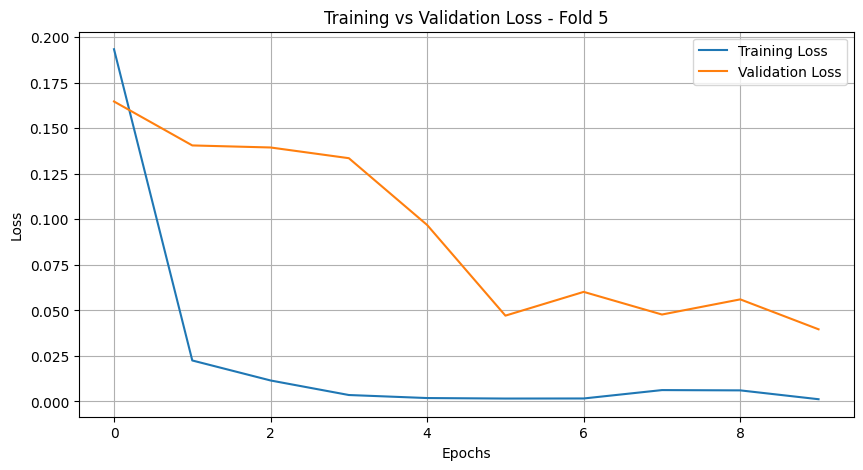

In [ ]:
# Setup logging
logging.basicConfig(level=logging.INFO, filename='training_log.log', filemode='w',
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Define the model parameters
input_shape = (224, 224, 3)
weights = 'imagenet'
batch_size = 256
img_size = 224
num_classes = 2
num_folds = 5
num_epochs = 10

# Function to build the model
def build_model():
    base_model = Xception(include_top=False, input_shape=input_shape, weights=weights, pooling='avg')
    base_model.trainable = True  # Fine-tuning

    model = Sequential([
        base_model,
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.00039898749499904464),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Function to save history
def save_history(history, filename):
    with open(filename, 'w') as f:
        json.dump(history.history, f)

# Configure the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Apply KFold Cross Validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=50)

fold_var = 1

for train_index, val_index in kf.split(train_df):
    training_data = train_df.iloc[train_index]
    validation_data = train_df.iloc[val_index]

    # Create generators for training and validation
    train_generator = datagen.flow_from_dataframe(
        dataframe=training_data,
        directory=train_path,
        x_col='filename',
        y_col='class',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='binary')

    validation_generator = datagen.flow_from_dataframe(
        dataframe=validation_data,
        directory=train_path,
        x_col='filename',
        y_col='class',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='binary')

    # Build and train the model
    model = build_model()
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=num_epochs,
        verbose=1
    )

    # Saving the model after each fold
    model_path = os.path.join('/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas', f'fold_{fold_var}_model.keras')
    model.save(model_path)

    # Save the history
    history_path = os.path.join('/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas', f'fold_{fold_var}_history.json')
    save_history(history, history_path)

    # Plot training and validation loss for current fold
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training vs Validation Loss - Fold {fold_var}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    fold_var += 1


# Evaluate


In [5]:
from keras.models import load_model

def zero_one_loss(y_true, y_pred):
    return 1 - tf.keras.metrics.binary_accuracy(y_true, y_pred)

# Path to your saved model
model_path = '/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/checkpoints/best_model_trial_16_val_loss_0.0265.keras'

# Load the model
model = load_model(model_path, custom_objects={'zero_one_loss': zero_one_loss})


In [10]:
test_loss, test_accuracy, zero_one_loss = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Zero-One Loss: {zero_one_loss}')

5/5 [==============================] - 296s 58s/step - loss: 0.0456 - accuracy: 0.9899 - zero_one_loss: 0.0101
Test Loss: 0.04563785716891289
Test Accuracy: 0.9898648858070374
Zero-One Loss: 0.010135134682059288


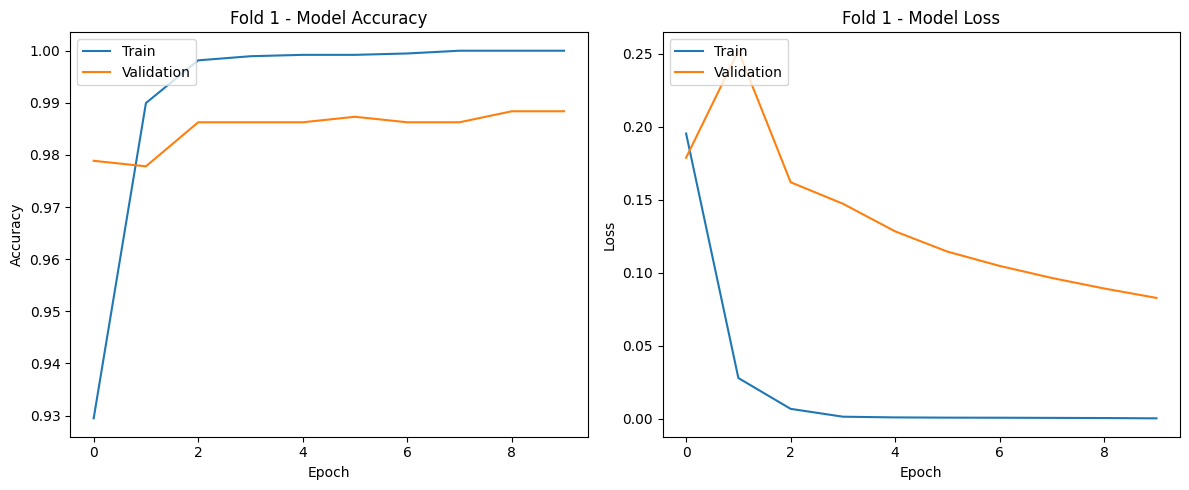

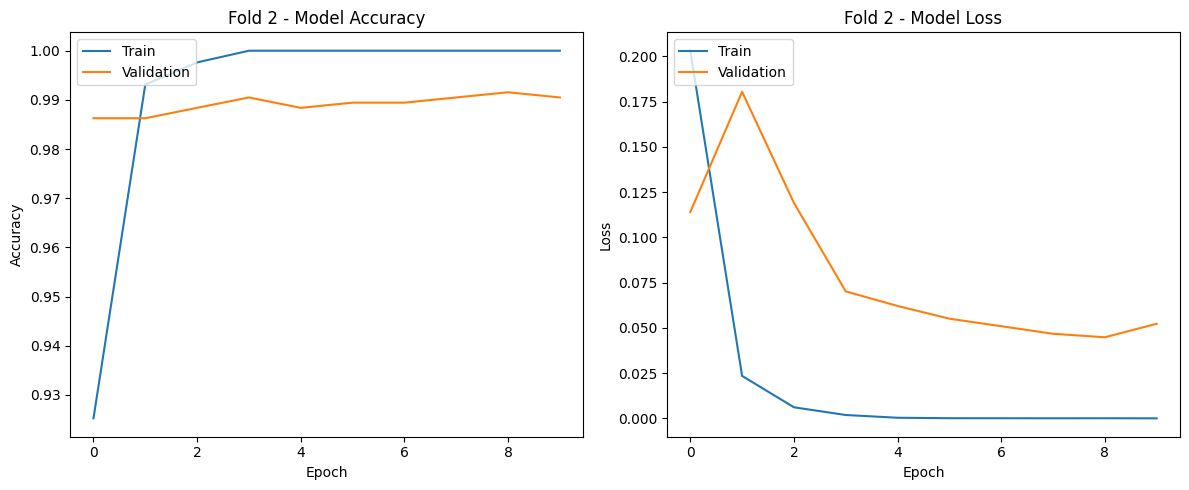

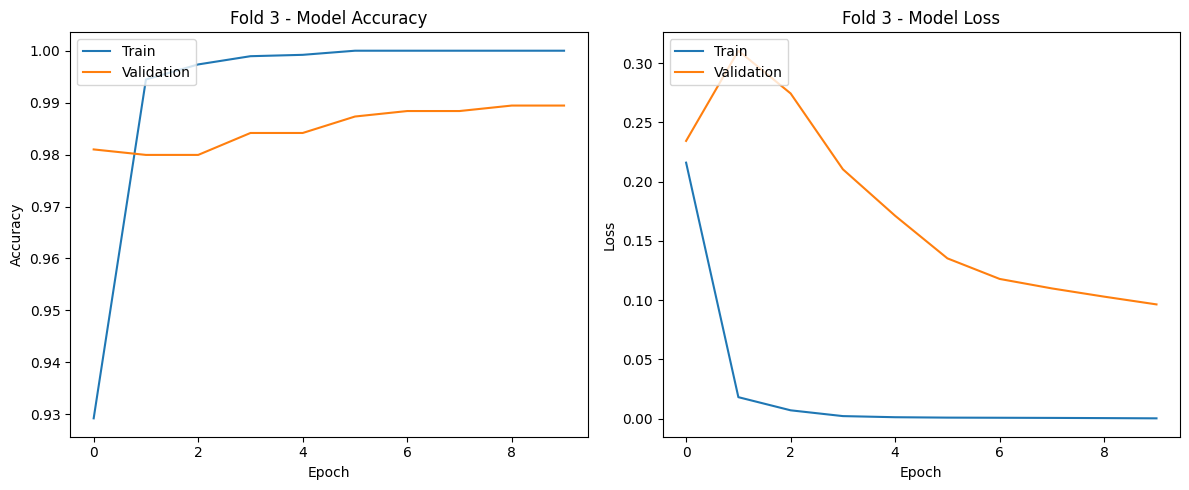

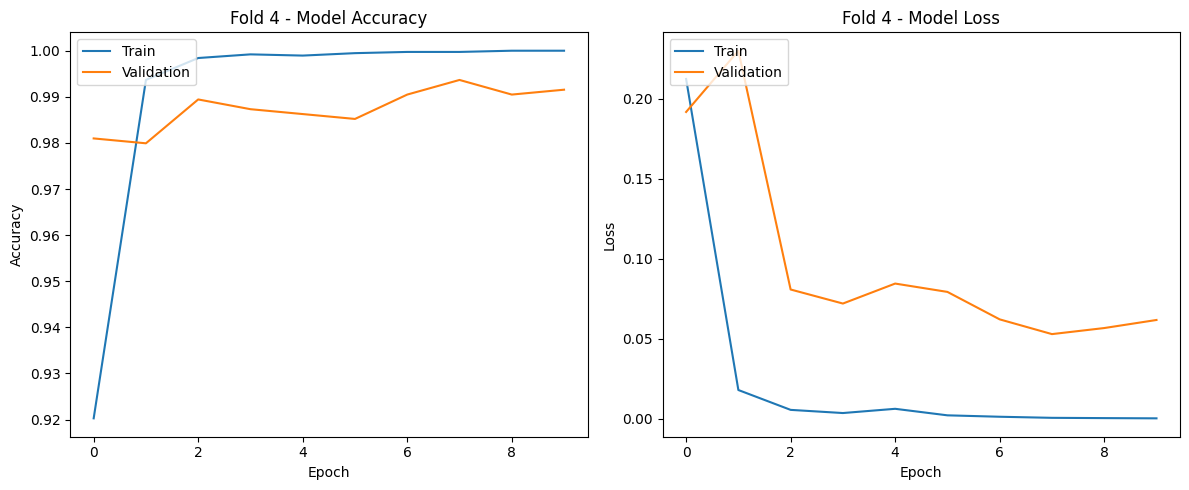

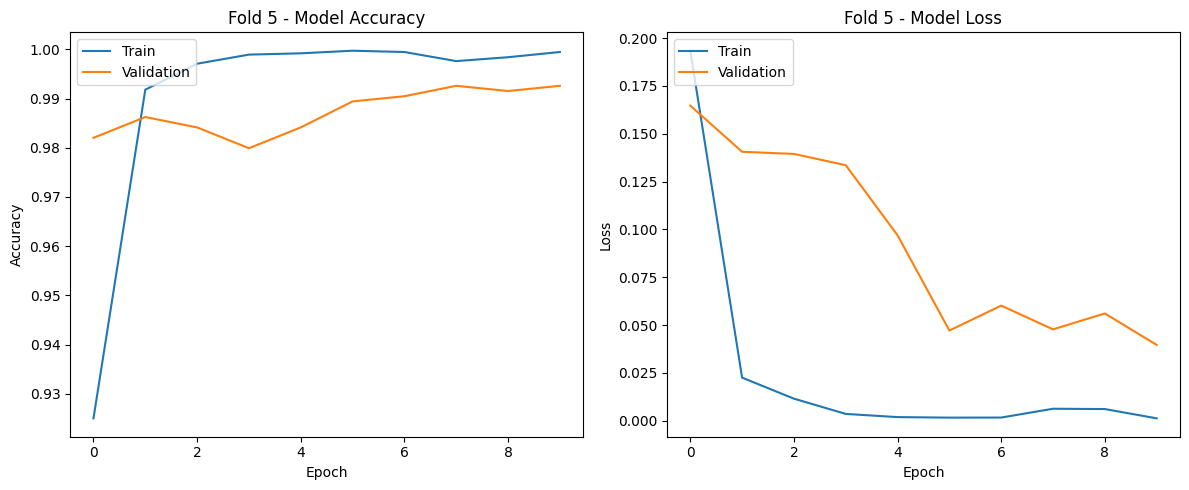

In [9]:
def plot_metrics(histories, metric_names=['accuracy', 'loss']):
    for i, history in enumerate(histories):
        plt.figure(figsize=(12, 5))

        for j, metric in enumerate(metric_names):
            train_metric = metric if metric in history else 'acc' if 'acc' in history else 'accuracy'
            val_metric = 'val_' + train_metric
            plt.subplot(1, 2, j+1)
            plt.plot(history[train_metric], label='Train')
            plt.plot(history[val_metric], label='Validation')
            plt.title(f'Fold {i + 1} - Model {metric.capitalize()}')
            plt.xlabel('Epoch')
            plt.ylabel(metric.capitalize())
            plt.legend(loc='upper left')

        plt.tight_layout()
        plt.show()



def load_history(path):
    with open(path, 'r') as file:
        history = json.load(file)
    return history

# Paths to the saved history files for each fold
history_paths = ['/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/fold_1_history.json', '/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/fold_2_history.json', '/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/fold_3_history.json', '/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/fold_4_history.json', '/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/fold_5_history.json']

histories = [load_history(path) for path in history_paths]

plot_metrics(histories)


In [10]:
val_losses = [np.min(history['val_loss']) for history in histories]
val_accuracies = [np.max(history['val_accuracy']) for history in histories]

avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)

print(f'Average Validation Loss: {avg_val_loss}')
print(f'Average Validation Accuracy: {avg_val_accuracy}')

Average Validation Loss: 0.06332944184541703
Average Validation Accuracy: 0.9911269903182983


In [ ]:
# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)

# Get true labels from the generator
true_classes = test_generator.classes

# Calculate zero-one loss manually
zero_one_loss_value = np.sum(predicted_classes.flatten() != true_classes) / len(true_classes)
print(f"Zero-One Loss on Test Data: {zero_one_loss_value}")


5/5 [==============================] - 277s 64s/step
Zero-One Loss on Test Data: 0.004222972972972973


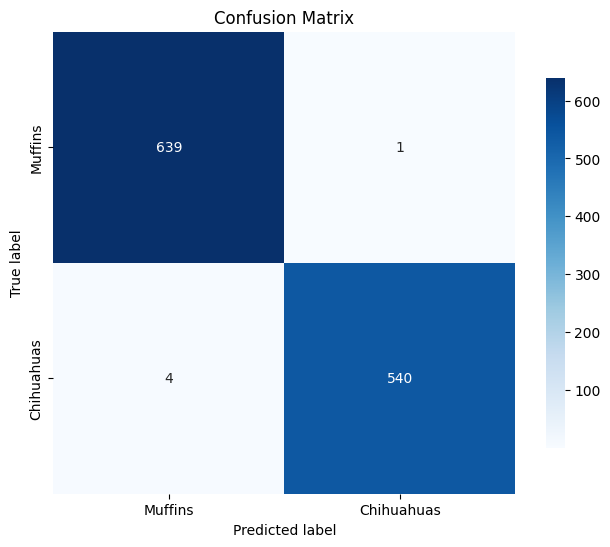

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True, cbar_kws={'shrink': .8},
            xticklabels=['Muffins', 'Chihuahuas'],
            yticklabels=['Muffins', 'Chihuahuas'])

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# models vs val_loss

In [ ]:
def extract_data_grouped_by_architecture(base_path):
    trial_folders = os.listdir(base_path)
    data_by_architecture = {}

    for folder in trial_folders:
        json_file_path = os.path.join(base_path, folder, 'trial.json')
        if os.path.exists(json_file_path):
            with open(json_file_path, 'r') as file:
                data = json.load(file)

                architecture = data.get('hyperparameters', {}).get('values', {}).get('architecture', 'Unknown')

                # Attempt to extract val_loss
                try:
                    val_loss = data['metrics']['metrics']['val_loss']['observations'][0]['value'][0]
                except KeyError:
                    continue  # Skip this file silently if val_loss is not found

                units = data.get('hyperparameters', {}).get('values', {}).get('units', 'Unknown')
                activation = data.get('hyperparameters', {}).get('values', {}).get('activation', 'Unknown')
                dropout = data.get('hyperparameters', {}).get('values', {}).get('dropout', 'Unknown')
                learning_rate = data.get('hyperparameters', {}).get('values', {}).get('learning_rate', 'Unknown')

                title = f"Units: {units}, Act: {activation}, Dropout: {dropout}, LR: {learning_rate}"

                if architecture not in data_by_architecture:
                    data_by_architecture[architecture] = []
                data_by_architecture[architecture].append((title, val_loss))

    return data_by_architecture


In [ ]:
def plot_val_losses_grouped(data_by_architecture):
    for architecture, trials in data_by_architecture.items():
        plt.figure(figsize=(14, 8))
        titles, val_losses = zip(*trials)  # Unpack titles and validation losses

        # Sort data by validation loss for better visualization
        sorted_data = sorted(zip(titles, val_losses), key=lambda x: x[1])
        titles_sorted, val_losses_sorted = zip(*sorted_data)

        # Create a horizontal bar plot
        y_positions = range(len(titles_sorted))
        plt.barh(y_positions, val_losses_sorted, color='blue')
        plt.yticks(y_positions, titles_sorted)
        plt.xlabel('Validation Loss')
        plt.title(f'Validation Loss for {architecture}')

        # Adding the exact loss values on the bars
        for index, value in enumerate(val_losses_sorted):
            plt.text(value, index, f'{value:.4f}', va='center', ha='right', color='black')

        plt.gca().invert_yaxis()  # Invert y-axis to have the lowest loss at the top
        plt.tight_layout()
        plt.show()

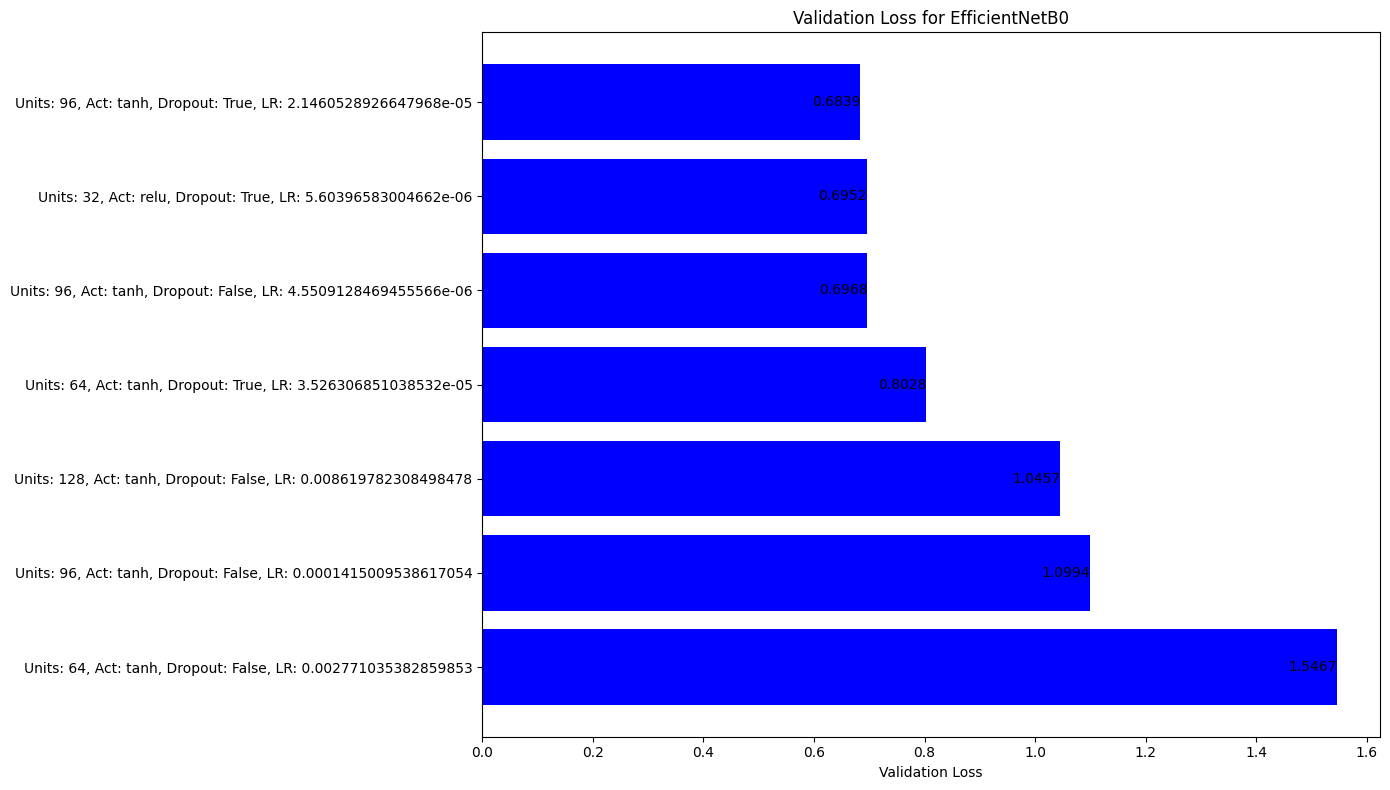

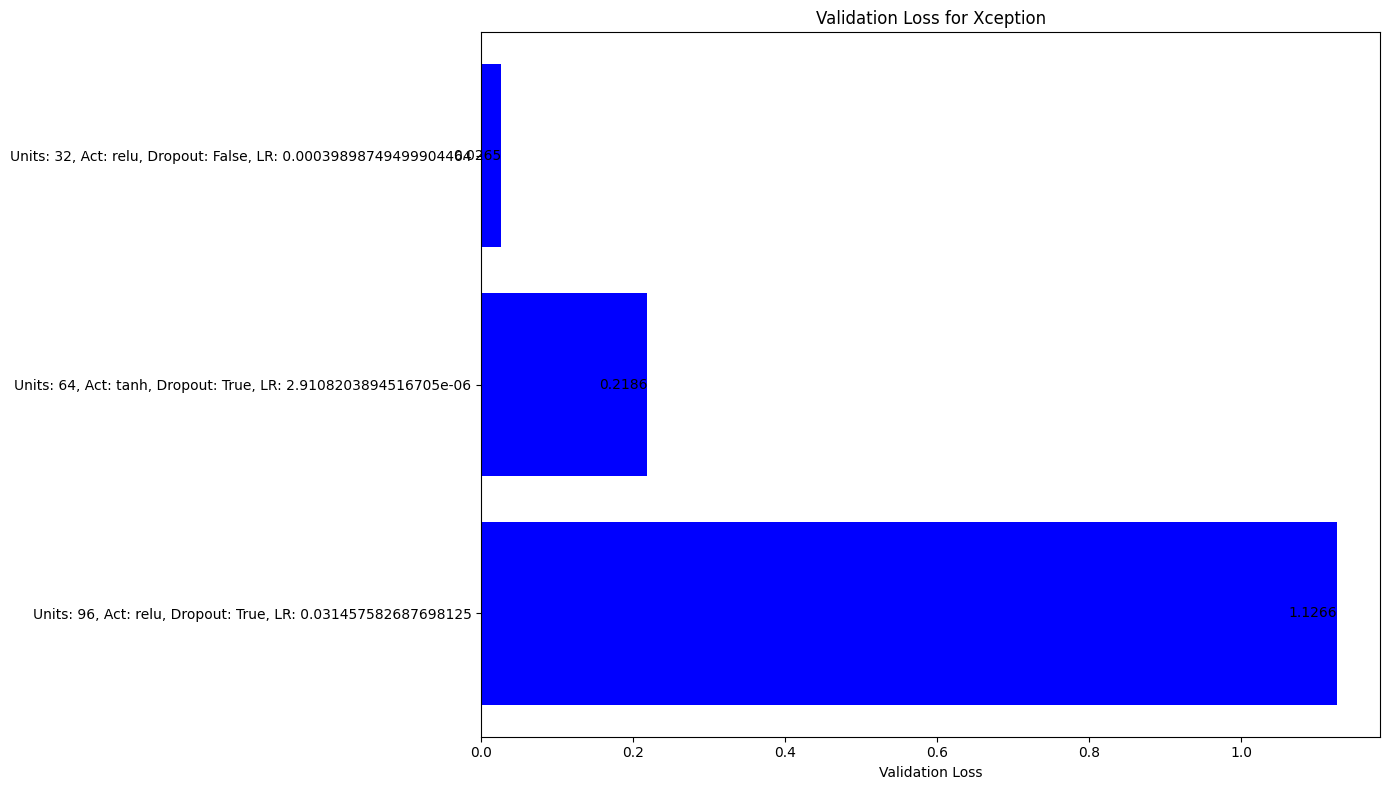

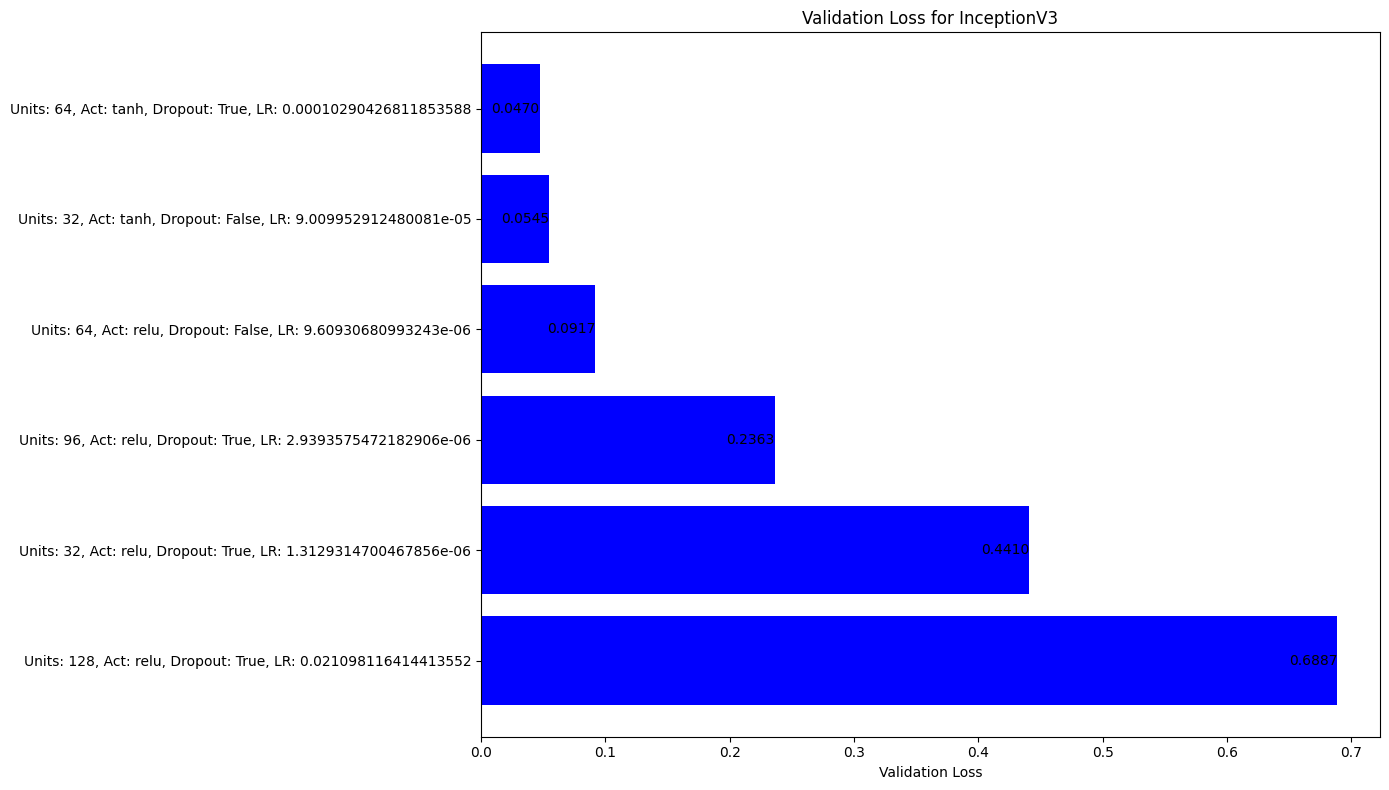

In [ ]:
# Path to your JSON files
json_path = '/content/drive/MyDrive/ML_Project_Muffins_Chihuahuas/dir/muffin_chihuahua_classification'

# Extract data grouped by architecture
data_by_architecture = extract_data_grouped_by_architecture(json_path)

# Plot the results
plot_val_losses_grouped(data_by_architecture)
